<center><font size = "10"> Week 7 - Connections<center>
<center><font size = "8">Tutorial 01: all-to-all with Random Weights<center>

<font size='3'><font color='blue'> In this tutorial you will learn: 
    
<font size='3'><font color='blue'>- how to connect several cells between them
    
<font size='3'><font color='blue'>- plot the weight connectivity matrix

In [1]:
# Load useful packages
import os
from neuron import h, gui
import numpy as np
import math as m
import random as rd

import matplotlib.pyplot as plt
%matplotlib inline

--No graphics will be displayed.


## Step 1: Create the cell class

In [2]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self) # Notice this change to be able to instantiate several cells
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

## Step 2: Instantiate different cells

<font size='3'> Load cells so you will be able to run simulations on them.

<font color="red">___IMPORTANT:___ This cell might show an error. Don't pay attention to it, is not a fatal error and the cells got properly instantiated.

In [3]:
Pyr1 = Cell('input/example_morphologies/Pyr_01.swc','Pyr1','Pyr')
Pyr2 = Cell('input/example_morphologies/Pyr_02.swc','Pyr2','Pyr')
Int1 = Cell('input/example_morphologies/Int_01.swc','Int1','Int')
cells_Pyr = [Pyr1, Pyr2]
cells_Int = [Int1]
cells = cells_Pyr + cells_Int

<font size='3'> Print the number of sections per neurite. Realize that the inhibitory cell doesn't have an apical neurite.

In [4]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon sections' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon sections' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 73 apical sections, 72 basal sections, 1 soma sections and 281 axon sections
Pyr2: 67 apical sections, 47 basal sections, 1 soma sections and 123 axon sections
Int1: 69 basal sections, 1 soma sections and 323 axon sections


## Step 3: Connect all to all (uni-directional) with random weights

<font size='3'> For this purpose we created some functions: one generates a matrix with random weigths and the other connects two cells using [h.ExpSyn](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html#ExpSyn) and [h.NetCon](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html)

In [5]:
# returns NxN matrix of random weights in [0,1) with zero diagonal
def random_weights(n):
    rng = np.random.default_rng()
    weights = rng.random((n,n))
    np.fill_diagonal(weights,0.0)
    return weights

In [6]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    rng = np.random.default_rng()
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return netcon

<font size='3'> Run the previous functions

In [7]:
weight_matrix = random_weights(3)

netcons = [] # save the netcons in case we want to modify them later

# Connect Pyr2 and Int1 to Pyr1
nc = connect(Pyr2,Pyr1,weight_matrix[0,1])
netcons.append(nc)
nc = connect(Int1,Pyr1,weight_matrix[0,2],target_neurite='soma')
netcons.append(nc)

# Connect Pyr1 and Int1 to Pyr2
nc = connect(Pyr1,Pyr2,weight_matrix[1,0])
netcons.append(nc)
nc = connect(Int1,Pyr2,weight_matrix[1,2],target_neurite='soma')
netcons.append(nc)

# Connect Pyr1 and Pyr2 to Int1
nc = connect(Pyr1,Int1,weight_matrix[2,0])
netcons.append(nc)
nc = connect(Pyr2,Int1,weight_matrix[2,1])
netcons.append(nc)

Connected cells Pyr2 -> Pyr1 with weight 0.893564 and delay 5, from axon[76] to dend[9]
Connected cells Int1 -> Pyr1 with weight 0.416304 and delay 5, from axon[106] to soma[0]
Connected cells Pyr1 -> Pyr2 with weight 0.539277 and delay 5, from axon[159] to dend[19]
Connected cells Int1 -> Pyr2 with weight 0.118405 and delay 5, from axon[132] to soma[0]
Connected cells Pyr1 -> Int1 with weight 0.6406 and delay 5, from axon[140] to dend[41]
Connected cells Pyr2 -> Int1 with weight 0.961583 and delay 5, from axon[100] to dend[43]


<font size='3'>To test connectivity, let's stimulate one neuron and record another

In [8]:
stim_cell = Pyr2
stim_syn = h.ExpSyn(stim_cell.dend[42](0.5))
stim = h.NetStim() # Make a new stimulator
ncstim = h.NetCon(stim, stim_syn) # Connect stimulator to synapse

<font size='3'>You can play with the parameters below and rerun to see the change in the voltage traces

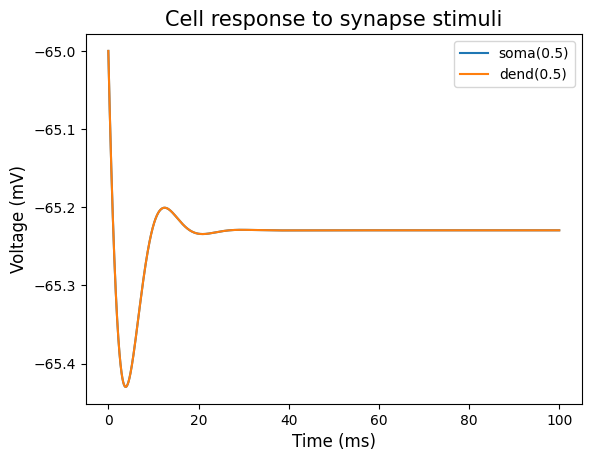

In [9]:
stim.number = 10 # Number of spikes (average)
stim.start = 10 # First spike delay [ms]
ncstim.delay = 1 # NetCon ms
ncstim.weight[0] = 0.8 # NetCon weight

recording_cell = Pyr1

soma_v = h.Vector().record(recording_cell.soma[0](0.5)._ref_v)
dend_v = h.Vector().record(recording_cell.dend[42](0.5)._ref_v)
time = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(100)

fig, ax = plt.subplots()

ax.plot(time, soma_v, label='soma(0.5)')
ax.plot(time, dend_v,  label='dend(0.5)')

ax.set_title("Cell response to synapse stimuli", fontsize = 15)
ax.set_xlabel("Time (ms)", fontsize = 12)
ax.set_ylabel("Voltage (mV)", fontsize = 12)
ax.legend(loc='upper right')

plt.show()

## Step4: Connection weight matrix (between cells)

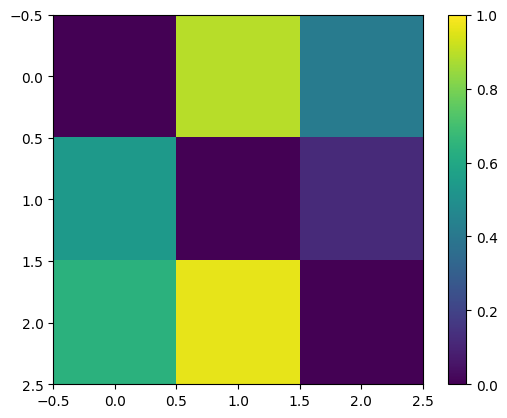

In [10]:
# This is the simplest way to plot the matrix
color_map = plt.imshow(weight_matrix, cmap="viridis", vmin=0.0, vmax=1.0)
plt.colorbar()

<font size='3'> Let's plot the matrix with lables

In [11]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

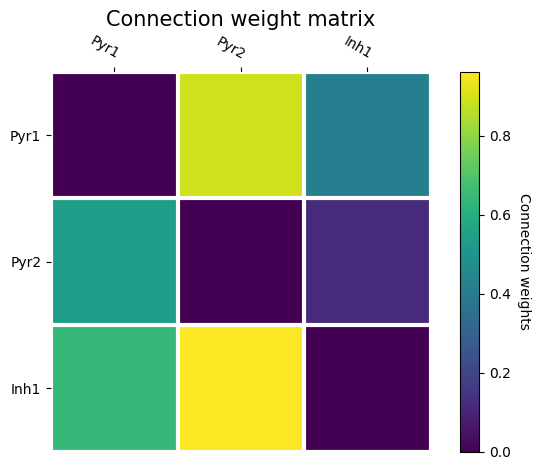

In [12]:
fig, ax = plt.subplots()

im, cbar = heatmap(weight_matrix,
                   ['Pyr1', 'Pyr2', 'Inh1'],
                   ['Pyr1', 'Pyr2', 'Inh1'], 
                   ax=ax, cmap="viridis", cbarlabel="Connection weights")

ax.set_title("Connection weight matrix", fontsize = 15)
fig.tight_layout()